# Analysis

In [7]:
import os, glob
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read input data

In [20]:
def script_read_multiruns():
    IN_PARENT_DIR = '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-18/12-26-47'
    Prog_File_wc = '*/run_*/progress.csv'
    Config_File_wc = '*/.hydra/config.yaml'
    
    PD_DF_SEP = ','
    
    
    def get_progress_file_dict_key(path_str):
        """Helper method to get dict key for both the progress files
        and the config files"""
        return path_str.split('/')[-3]
    
    def get_config_file_dict_key(path_str):
        return get_progress_file_dict_key(path_str)
        
    mr_dict = {}
    
    for path in glob.glob(os.path.join(IN_PARENT_DIR, Prog_File_wc)):
        d_k = get_progress_file_dict_key(path)
        mr_dict[d_k] = {
            'df': pd.read_csv(path, sep=PD_DF_SEP)
        }
    
    for path in glob.glob(os.path.join(IN_PARENT_DIR, Config_File_wc)):
        d_k = get_config_file_dict_key(path)
        mr_dict[d_k]['config'] = yaml.load(open(path))
    
    return mr_dict
        
        

DataDict = script_read_multiruns()
len(DataDict)

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


206

#### Get all attributes into columns and concate all runs

In [52]:
import collections

def construct_data_df(runs_dict):    
    def recursive_helper(configDict, curStr='', headerDict={}):
        """Helper to extract all the nested attributes into a
        single attribute dict"""
        # Base case: no child dictionaries
        if not isinstance(configDict, collections.Mapping):
            headerDict[curStr] = str(configDict)
            return None
        
        # Recursion
        for k in configDict:
            if len(curStr) == 0:
                childStr = k
            else:
                childStr = f'{curStr}.{k}'
            recursive_helper(configDict[k], childStr, headerDict)
        return None
    
    # ==
    # Add configs to dataframes and concat
    all_df_list = []
    
    for run_k in runs_dict:
        cur_run_dict = runs_dict[run_k]
        
        # Extract header
        config_dict = {}
        recursive_helper(cur_run_dict['config'], 
                         curStr='', 
                         headerDict=config_dict)
        
        
        # Add to dataframe
        cur_df = cur_run_dict['df'].copy(deep=True)
        for header_k in config_dict:
            col_val = config_dict[header_k]
            cur_df[header_k] = [col_val] * len(cur_df)
            
        
        all_df_list.append(cur_df)
        
    # ==
    # Concat and output
    all_concat_df = pd.concat(all_df_list)
    all_concat_df = all_concat_df.reset_index()
    
    return all_concat_df


Data_df = construct_data_df(DataDict)
print(len(Data_df))
Data_df[0:3]

41132


,index,Diagnostics/NewCompletedTrajs,Diagnostics/StepsInTrajWindow,Diagnostics/Iteration,Diagnostics/CumTime (s),Diagnostics/CumSteps,Diagnostics/CumCompletedTrajs,Diagnostics/CumUpdates,Diagnostics/StepsPerSecond,Diagnostics/UpdatesPerSecond,...,algo.kwargs.sf_lambda,algo.kwargs.learning_rate,algo.kwargs.value_loss_coeff,algo.kwargs.sf_loss_coeff,algo.kwargs.reward_loss_coeff,algo.kwargs.entropy_loss_coeff,algo.kwargs.clip_grad_norm,algo.kwargs.gae_lambda,algo.kwargs.normalize_advantage,algo.kwargs.initial_optim_state_dict
0,0,15,406,249,1.980379,500,15,250,252.476881,126.238441,...,0.5,0.001,0.5,0.1,0.5,0.01,1.0,0.0,False,None
1,1,7,901,499,3.867484,1000,22,500,264.956212,132.478106,...,0.5,0.001,0.5,0.1,0.5,0.01,1.0,0.0,False,None
2,2,8,1443,749,5.903163,1500,30,750,245.618194,122.809097,...,0.5,0.001,0.5,0.1,0.5,0.01,1.0,0.0,False,None


In [57]:
print(Data_df.columns.values.tolist())

['index', 'Diagnostics/NewCompletedTrajs', 'Diagnostics/StepsInTrajWindow', 'Diagnostics/Iteration', 'Diagnostics/CumTime (s)', 'Diagnostics/CumSteps', 'Diagnostics/CumCompletedTrajs', 'Diagnostics/CumUpdates', 'Diagnostics/StepsPerSecond', 'Diagnostics/UpdatesPerSecond', 'Diagnostics/ReplayRatio', 'Diagnostics/CumReplayRatio', 'Length/Average', 'Length/Std', 'Length/Median', 'Length/Min', 'Length/Max', 'Return/Average', 'Return/Std', 'Return/Median', 'Return/Min', 'Return/Max', 'NonzeroRewards/Average', 'NonzeroRewards/Std', 'NonzeroRewards/Median', 'NonzeroRewards/Min', 'NonzeroRewards/Max', 'DiscountedReturn/Average', 'DiscountedReturn/Std', 'DiscountedReturn/Median', 'DiscountedReturn/Min', 'DiscountedReturn/Max', 'loss/Average', 'loss/Std', 'loss/Median', 'loss/Min', 'loss/Max', 'gradNorm/Average', 'gradNorm/Std', 'gradNorm/Median', 'gradNorm/Min', 'gradNorm/Max', 'entropy/Average', 'entropy/Std', 'entropy/Median', 'entropy/Min', 'entropy/Max', 'perplexity/Average', 'perplexity/St

## Explatory Plots

In [59]:
set(Data_df['sampler.kwargs.batch_T'].values)

{'2'}

In [60]:
set(Data_df['algo.kwargs.sf_lambda'].values)

{'0.0', '0.3', '0.5', '0.9', '1.0'}

In [61]:
set(Data_df['model.kwargs.sf_hidden_sizes'].values)

{'[1024, 1024]', '[1024]'}

In [62]:
set(Data_df['model.kwargs.detach_sf_grad'].values)

{'False', 'True'}

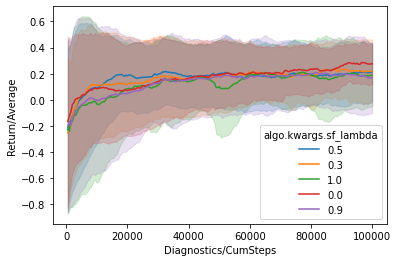

In [70]:
def simple_lineplot(x, y, hue, data, filters={}):
    df = data.copy(deep=True)
    for f_k in filters:
        df = df[df[f_k] == filters[f_k]]
    
    sns.lineplot(x=x, y=y, hue=hue, 
                 ci='sd',
                 data=df)
        
simple_lineplot(
    x='Diagnostics/CumSteps', y='Return/Average', 
    hue='algo.kwargs.sf_lambda', 
    data=Data_df,
    filters={'model.kwargs.detach_sf_grad': 'False', 'model.kwargs.sf_hidden_sizes': '[1024]'}
)

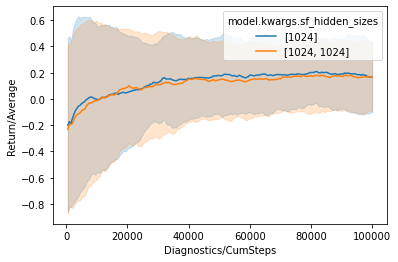

In [71]:
simple_lineplot(
    x='Diagnostics/CumSteps', y='Return/Average', 
    hue='model.kwargs.sf_hidden_sizes', 
    data=Data_df,
    filters={
        'algo.kwargs.sf_lambda': '0.9',
        'model.kwargs.detach_sf_grad': 'False', 
    }
)

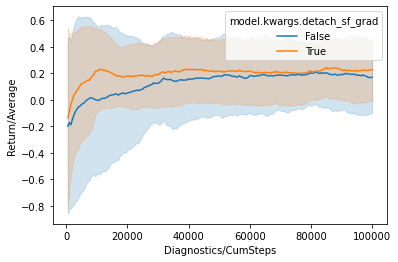

In [72]:
simple_lineplot(
    x='Diagnostics/CumSteps', y='Return/Average', 
    hue='model.kwargs.detach_sf_grad', 
    data=Data_df,
    filters={
        'algo.kwargs.sf_lambda': '0.9',
        'model.kwargs.sf_hidden_sizes': '[1024]', 
    }
)

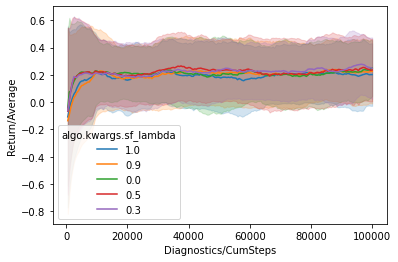

In [73]:
simple_lineplot(
    x='Diagnostics/CumSteps', y='Return/Average', 
    hue='algo.kwargs.sf_lambda', 
    data=Data_df,
    filters={'model.kwargs.detach_sf_grad': 'True', 'model.kwargs.sf_hidden_sizes': '[1024]'}
)